# VAE model building

## Import module

In [1]:
from keras.layers import Lambda,Input,Dense,Flatten,Conv2D,Conv2DTranspose
from keras.layers import Activation,BatchNormalization,Reshape,Concatenate,Dropout
from keras.models import Model
from keras.losses import mse, binary_crossentropy
from keras.callbacks import Callback,ModelCheckpoint,ReduceLROnPlateau
from keras.utils import to_categorical
from keras import backend as K
from keras.optimizers import Adam
from keras import initializers
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
import cv2
from mnist import MNIST

Using TensorFlow backend.


In [2]:
emndata = MNIST('emnist_data')
img_rows = 28
img_cols = 28
img_channel = 1
orig_dimension = img_rows*img_cols

X_train,y_train = emndata.load('emnist_data/emnist-byclass-train-images-idx3-ubyte',
                               'emnist_data/emnist-byclass-train-labels-idx1-ubyte')
X_test,y_test = emndata.load('emnist_data/emnist-byclass-test-images-idx3-ubyte',
                             'emnist_data/emnist-byclass-test-labels-idx1-ubyte')
X_train = np.array(X_train)
# X_train = X_train.reshape(X_train.shape[0],img_rows,img_cols)
y_train = np.array(y_train)
X_test = np.array(X_test)
# X_test = X_test.reshape(X_test.shape[0],img_rows,img_cols)
y_test = np.array(y_test)


print('X_train shape: {}'.format(X_train.shape))
print('X_test shape: {}'.format(X_test.shape))
print('y_train shape: {}'.format(y_train.shape))
print('y_test shape: {}'.format(y_test.shape))

X_train shape: (697932, 784)
X_test shape: (116323, 784)
y_train shape: (697932,)
y_test shape: (116323,)


In [3]:
# for i in range(X_train.shape[0]):
#     X_train[i]=np.transpose(X_train[i])
# for i in range(X_test.shape[0]):
#     X_test[i]=np.transpose(X_test[i])

By Class: This represents the most useful organization
from a classification perspective as it contains the segmented digits and characters arranged by class. There are
62 classes comprising [0-9], [a-z] and [A-Z]. The data is
also split into a suggested training and testing set.

In [4]:
label_str = '0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz'
lebel_dict = {i:v for i,v in enumerate(label_str)}

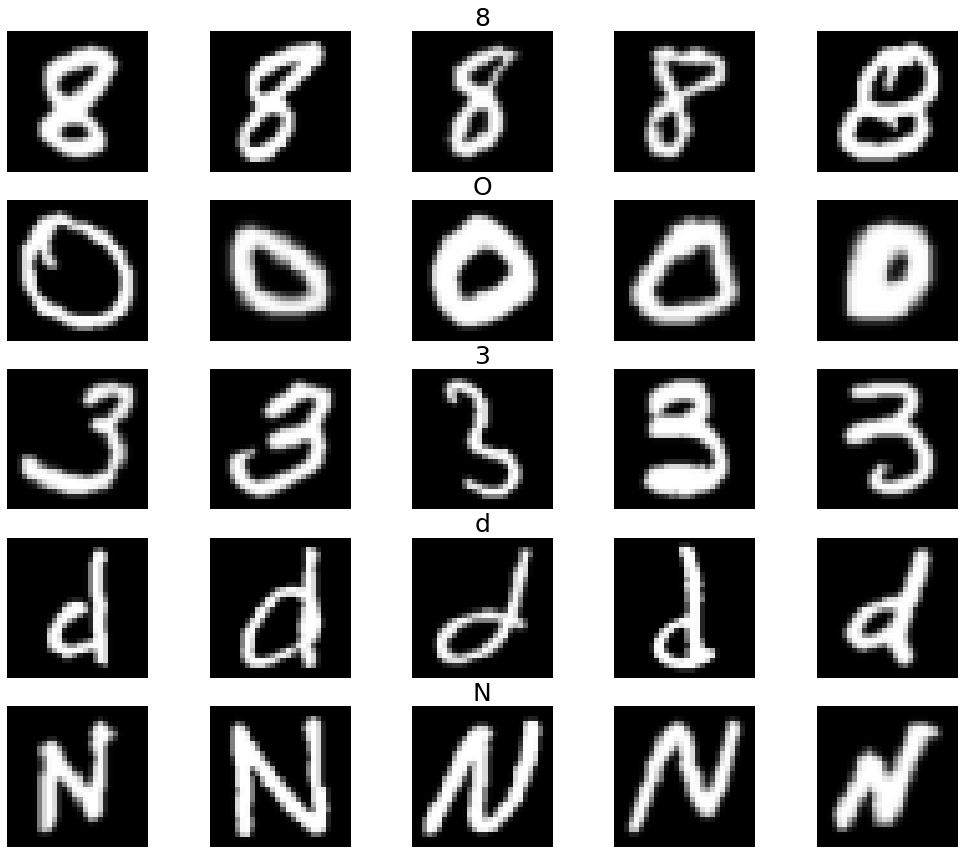

In [5]:
np.random.seed(100)
n_samples = 5
n_cls = 5
n_label = len(np.unique(y_train))
fig, rows = plt.subplots(n_cls,n_samples,figsize=(4*n_samples,3*n_cls))

for row,cls in zip(rows,np.random.choice(list(range(n_label)),n_cls)):
    row[int(np.floor(n_samples/2))].set_title(lebel_dict[cls],fontsize=25)
    for col_ax,img_idx in zip(row,[i for i,v in enumerate(y_train) if v==cls][:n_samples]):
        img = X_train[img_idx].reshape(img_rows,img_cols)
        img = np.transpose(img)
        col_ax.imshow(img,cmap='gray')
        col_ax.axis('off')
plt.subplots_adjust(left=0.2, wspace=0.02)

In [6]:
# y_train = list(map(lambda x:lebel_dict[x], y_train))
# y_test = list(map(lambda x:lebel_dict[x], y_test))

In [7]:
X_train = X_train.astype('float32')/(255/2)-1 # for tanh
X_test = X_test.astype('float32')/(255/2)-1
# X_train_flat = np.expand_dims(X_train_flat,-1)
# X_test_flat =  np.expand_dims(X_test_flat,-1)
print('X_train shape: {}'.format(X_train.shape))
print('X_test shape: {}'.format(X_test.shape))

X_train shape: (697932, 784)
X_test shape: (116323, 784)


In [8]:
y_train = to_categorical(y_train,n_label)
y_test = to_categorical(y_test,n_label)
print('y_train shape: {}'.format(y_train.shape))
print('y_test shape: {}'.format(y_test.shape))

y_train shape: (697932, 62)
y_test shape: (116323, 62)


In [9]:
def sampling(arg):
    arg = [z_mean,z_log_var]
    dim = K.int_shape(z_mean)[1]
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], dim),mean=0.0, stddev=1.0) # reparameterization trick
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

In [10]:
image_shape = (img_rows,img_cols,img_channel)
batch_size = 128
latent_dim = 10
epochs = 100
learning_rate = 0.001
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss',patience=10,verbose=1,factor=0.5,min_lr=0.00001)

## Encoder

In [11]:
w_init = initializers.random_normal(stddev=0.02)
gamma_init = initializers.random_normal(mean=1.0,stddev=0.02)

img_inputs = Input(shape=(orig_dimension,),name='image_input')
label_inputs = Input(shape=(n_label,),name='label_input')
encoder_inputs = Concatenate()([img_inputs,label_inputs])

x = Dense(orig_dimension,kernel_initializer=w_init,activation='relu')(encoder_inputs)

x = Reshape(image_shape)(x)
x = Conv2D(16,3,strides=1,padding='same',kernel_initializer=w_init)(x)
x = BatchNormalization(gamma_initializer=gamma_init)(x)
x = Activation('relu')(x)
x = Conv2D(32,3,strides=1,padding='same',kernel_initializer=w_init)(x)
x = BatchNormalization(gamma_initializer=gamma_init)(x)
x = Activation('relu')(x)
x = Conv2D(64,3,strides=2,padding='same',kernel_initializer=w_init)(x)
x = BatchNormalization(gamma_initializer=gamma_init)(x)
x = Activation('relu')(x)
before_flatten_shape = K.int_shape(x)
x = Flatten()(x)
x = Dense(128,kernel_initializer=w_init,activation='relu')(x)

z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)

z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

encoder = Model([img_inputs,label_inputs],[z_mean,z_log_var,z],name='encoder')
encoder.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image_input (InputLayer)        (None, 784)          0                                            
__________________________________________________________________________________________________
label_input (InputLayer)        (None, 62)           0                                            
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, 846)          0           image_input[0][0]                
                                                                 label_input[0][0]                
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 784)          664048      concatenate_1[0][0]              
__________

## Decoder

In [12]:
latent_inputs = Input(shape=(latent_dim,),name='latent_inputs')
# label_dec_inputs = Input(shape=(n_label,),name='label_dec')
decoder_inputs = Concatenate()([latent_inputs,label_inputs])

x = Dense(128,kernel_initializer=w_init,activation='relu')(decoder_inputs)
x = Dense(before_flatten_shape[1]*before_flatten_shape[2]*before_flatten_shape[3],activation='relu',kernel_initializer=w_init)(x)
x = Reshape((before_flatten_shape[1],before_flatten_shape[2],before_flatten_shape[3]))(x)

x = Conv2DTranspose(64,3,strides=1,padding='same',kernel_initializer=w_init)(x)
x = BatchNormalization(gamma_initializer=gamma_init)(x)
x = Activation('relu')(x)

x = Conv2DTranspose(32,3,strides=2,padding='same',kernel_initializer=w_init)(x)
x = BatchNormalization(gamma_initializer=gamma_init)(x)
x = Activation('relu')(x)

x = Conv2DTranspose(16,3,strides=1,padding='same',kernel_initializer=w_init)(x)
x = BatchNormalization(gamma_initializer=gamma_init)(x)
x = Activation('relu')(x)

x = Conv2DTranspose(img_channel,3,activation='tanh',padding='same',kernel_initializer=w_init)(x)
outputs = Flatten()(x)

# instantiate decoder model
decoder = Model([latent_inputs,label_inputs],outputs,name='decoder')
decoder.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
latent_inputs (InputLayer)      (None, 10)           0                                            
__________________________________________________________________________________________________
label_input (InputLayer)        (None, 62)           0                                            
__________________________________________________________________________________________________
concatenate_2 (Concatenate)     (None, 72)           0           latent_inputs[0][0]              
                                                                 label_input[0][0]                
__________________________________________________________________________________________________
dense_3 (Dense)                 (None, 128)          9344        concatenate_2[0][0]              
__________

## VAE

In [13]:
outputs = decoder([encoder([img_inputs,label_inputs])[2],label_inputs])
vae = Model([img_inputs,label_inputs], outputs)

In [14]:
beta = 1 # 1 --> regular VAE
reconstruction_loss = mse(img_inputs,outputs)

# reconstruction_loss = mse(K.flatten(inputs), K.flatten(outputs))
# reconstruction_loss = binary_crossentropy(K.flatten(inputs),K.flatten(outputs))
reconstruction_loss *= img_rows*img_cols

kl_loss = -0.5*beta*K.sum(1+z_log_var-K.square(z_mean)-K.exp(z_log_var),axis=-1)
vae_loss = K.mean(reconstruction_loss+kl_loss)

In [15]:
vae.add_loss(vae_loss) ## in this case, we set y value to NONE during the fit
vae.compile(optimizer=Adam(lr=learning_rate))
vae.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image_input (InputLayer)        (None, 784)          0                                            
__________________________________________________________________________________________________
label_input (InputLayer)        (None, 62)           0                                            
__________________________________________________________________________________________________
encoder (Model)                 [(None, 10), (None,  2296132     image_input[0][0]                
                                                                 label_input[0][0]                
__________________________________________________________________________________________________
decoder (Model)                 (None, 784)          1688129     encoder[1][2]                    
          

In [16]:
os.makedirs('best_weight_ldg_v1',exist_ok=True)
best_model_weight_path = os.path.join('best_weight_ldg_v1','ldg_v1'+'-best-wiehgts'+'-{epoch:03d}-{loss:.3f}-{val_loss:.3f}.h5')
save_best_model = ModelCheckpoint(best_model_weight_path,monitor='val_loss',verbose=0,save_weights_only=True,save_best_only=True,mode='min')

class NEpochPrint(Callback):
    def __init__(self, display_step):
        self.epoch = 0
        self.display_step = display_step
    def on_epoch_end(self,epoch,logs={}):
        self.epoch += 1        
        if self.epoch == 1 or self.epoch % self.display_step == 0:
            print('Epoch: {}/{} ..... {}: {:.4f} - {}: {:.4f}'.format(self.epoch,
                                                                      self.params['epochs'],
                                                                      self.params['metrics'][0], 
                                                                      logs.get(self.params['metrics'][0]),
                                                                      self.params['metrics'][1],               
                                                                      logs.get(self.params['metrics'][1])))
NEpochPrinter = NEpochPrint(display_step=5)

In [17]:
def train_or_load_weights(flag,weight_name=None):
    if flag == 'train':
        hist = vae.fit([X_train,y_train],
                       epochs=epochs,
                       batch_size=batch_size,
                       validation_data=([X_test,y_test],None),
                       verbose=1,)
                       #callbacks=[save_best_model,learning_rate_reduction,NEpochPrinter])
        vae.save_weights('ldg_weight.h5')
        return hist
    if flag == 'load':
        vae.load_weights(os.path.join('best_weight_ldg_v1',weight_name)) # load all the weights for encoder and decoder when loading for vae

In [18]:
hist = train_or_load_weights(flag='train')

Train on 697932 samples, validate on 116323 samples
Epoch 1/100
697932/697932 [==============================] - 205s 293us/step - loss: 198.1932 - val_loss: 196.2869
Epoch 2/100
320256/697932 [============>.................] - ETA: 1:44 - loss: 196.4370

KeyboardInterrupt: 

In [ ]:
def training_plot(hist,model_name):
    loss = [hist.history['loss'],hist.history['val_loss']]
    plt.plot(loss[0],color='b',label='training')
    plt.plot(loss[1],color='r',label='valid')
    plt.title(model_name,fontsize=18)
    plt.legend(loc='best',fontsize=13)
    plt.xlabel('epoch',fontsize=15)
    plt.ylabel('')
    plt.tick_params(axis='both',labelsize=13)

In [ ]:
training_plot(hist,'ldg_v1 training')

In [60]:
def plot_five_reconstruction(input_set,label_set,random_idx,encoder,decoder):
    fig, axes = plt.subplots(2,5,figsize=(15,5))
    for row,flag in zip(axes,['in_img','out_img']): 
        for col,idx in zip(row,random_idx):
            original = input_set[idx]
            if flag == 'in_img':
                original_img = original.reshape(img_rows,img_cols)
                original_img = np.transpose(original_img)
                col.imshow(original_img,cmap='bone')
                col.set_title('idx = {}\nlabel = {}\noriginal'.format(idx,lebel_dict[np.argmax(label_set[idx])]))
            if flag == 'out_img':
                encoded_z = encoder.predict([np.expand_dims(original,0),np.expand_dims(label_set[100],0)],batch_size=1)[2]
                predict = decoder.predict([encoded_z,np.expand_dims(label_set[idx],0)])
                predict = (0.5*predict) + 0.5 # image back to 0-1 from -1 - 1
                decoded = predict.reshape(img_rows,img_cols)
                decoded = np.transpose(decoded)
                col.imshow(decoded,cmap='bone')
                col.set_title('reconstructed')
            col.axis('off')

## Traing set reconstruction

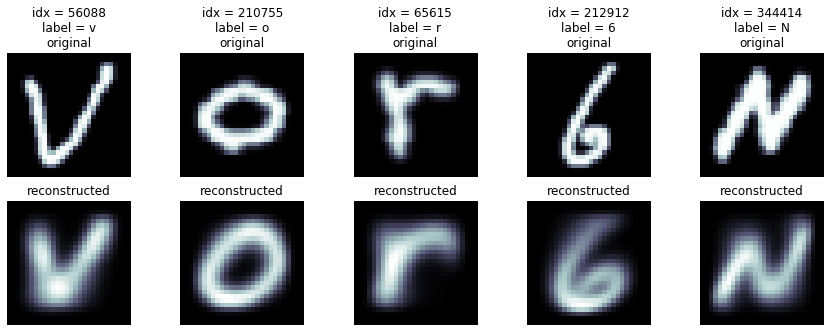

In [74]:
np.random.seed(100)
random_idx = np.random.randint(len(X_train),size=5)
plot_five_reconstruction(X_train,y_train,random_idx,encoder,decoder)

## Test set reconstruction

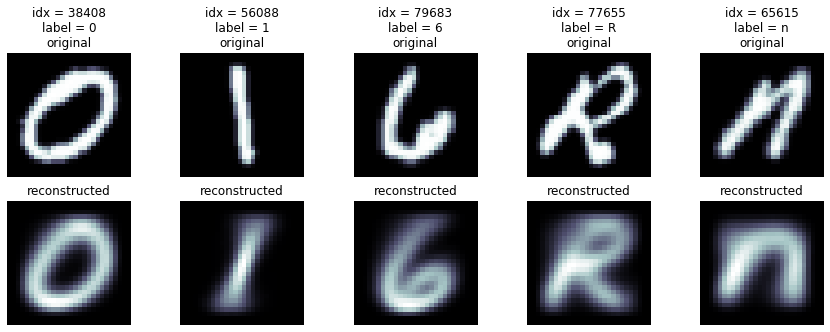

In [82]:
np.random.seed(100)
random_idx = np.random.randint(len(X_test),size=5)
plot_five_reconstruction(X_test,y_test,random_idx,encoder,decoder)

In [83]:
def digit_image(digit, latent=None):
    if latent is None:
        latent = np.random.randn(latent_dim)
    return from_latent(digit, latent)

def from_latent(num, vec):
    vec = np.array(vec)
    im = decoder.predict([vec.reshape(1, latent_dim), to_categorical([num], n_label)]).reshape(28, 28)
    return im

In [84]:
def find_idx_from_label_dict(search_str):
    for i,val in lebel_dict.items():
        if val == search_str:
            return i

In [152]:
def letter_digit_gen(input_str):
    np.random.seed(0)
    cls_idx = find_idx_from_label_dict(input_str)
    latent = np.random.randn(latent_dim)
    latent = np.expand_dims(np.random.randn(latent_dim),0)
    generated = decoder.predict([latent,np.expand_dims(to_categorical(cls_idx,n_label),0)])
    generated = (0.5*generated) + 0.5
    generated = generated.reshape(img_rows,img_cols)
    generated = np.transpose(generated)
    plt.imshow(generated)

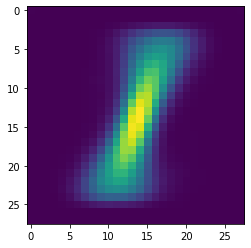

In [153]:
letter_digit_gen('1')

In [144]:
# plt.imshow(number_image(956),cmap='gray')

## Interpolation on the test set

In [ ]:
# X_test_encoded = encoder.predict(X_test[:10000], batch_size=1)[2][:,4:6]
# latent_space_df = pd.DataFrame(X_test_encoded,columns=['vector1','vector2'])
# latent_space_df['label'] = np.argmax(y_test[:10000],axis=1)
# latent_space_df.head()

# sns.set_context('paper', font_scale=1.5)
# sns.set_style('white')
# plt.figure()
# sns.lmplot('vector1','vector2',data=latent_space_df,hue='label',fit_reg=False,scatter_kws={'alpha':0.6,"s": 40},
#             height=8,palette=sns.color_palette("hls",latent_space_df['label'].nunique()))
# plt.title('Latent space by class')
# plt.show()

In [ ]:
# # not possible with label as input
# def interpolation(img1,img2,step,encoder,decoder,plot=True,saving_folder_name=None):
#     img1_encoded_z = encoder.predict(np.expand_dims(img1,0),batch_size=1)[2]
# #     print('1: {}'.format(img1_encoded_z))   
#     img2_encoded_z = encoder.predict(np.expand_dims(img2,0),batch_size=1)[2]
# #     print('2: {}'.format(img2_encoded_z))
#     step_size = (img2_encoded_z-img1_encoded_z)/step
# #     print('step: {}'.format(step_size))

#     step_list = [img1_encoded_z]
#     for _ in range(step):
#         img1_encoded_z = img1_encoded_z + step_size
#         step_list.append(img1_encoded_z)
#     if plot:
#         os.makedirs(saving_folder_name,exist_ok=True)
#         fig,axes = plt.subplots(int(np.ceil((step+1)/5)),5, figsize=(5*4, int(np.ceil((step+1)/5))*4))
#         for i,(ax,vector) in enumerate(zip(axes.flatten(),step_list)):
#             predict = decoder.predict(vector).reshape(img_rows,img_cols)
#             ax.imshow(predict,cmap='bone')
#             ax.axis('off')
            
#             predict = decoder.predict([encoded_z,np.expand_dims(label_set[idx],0)])
#             predict = (0.5*predict) + 0.5 # image back to 0-1 from -1 - 1
            
            
            
            
#             fig_indi,ax_indi = plt.subplots(figsize=(5,5))
#             ax_indi.imshow(predict,cmap='bone')
#             ax_indi.axis('off')
#             plt.title('step {}/{}'.format(i,step),fontsize=24,fontweight='bold')
#             fig_indi.savefig(os.path.join(saving_folder_name,'step_{}.png'.format(i)))
#             plt.close()
#             if i == 0:
#                 ax.set_title('From Image 1\n0%',fontsize=24,fontweight='bold')
#             elif i == step:
#                 ax.set_title('To Image 2\n100%',fontsize=24,fontweight='bold')
#             else:
#                 ax.set_title('step {}/{}\n{:.0f}%'.format(i,step,i*100/step),fontsize=24,fontweight='bold')
#         plt.subplots_adjust(hspace=0.3,left=0.1, wspace=0.02)
#         if (step+1)%5 != 0:
#             for i in axes.flatten()[(step+1)-len(axes.flatten()):]:
#                 i.set_visible(False)
#         fig.savefig(os.path.join(saving_folder_name,'summary.png'))
#     return step_list

In [ ]:
# np.random.seed(150)
# saving_folder_name='interpolation_images_EMNIST'
# random_idx_2 = np.random.randint(len(X_test),size=2)
# print(random_idx_2)
# _ = interpolation(X_test[random_idx_2[0]],X_test[random_idx_2[1]],10,encoder,decoder,plot=True,saving_folder_name=saving_folder_name)